In [1]:
!pip install albumentations > /dev/null
!pip install -U efficientnet==0.0.4
!pip install -U segmentation-models

import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD,Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image
import cv2

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
    
%matplotlib inline

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14288 sha256=0622900623c80eddfe34746a4a4c2c3d5a6849abb1d7ddd848db4d911ee14117
  Stored in directory: /tmp/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet
  Found existing installation: efficientnet 0.0.4
    Uninstalling efficientnet-0.0.4:
      Successfully uninstalled efficientnet-0.0.4


Using TensorFlow backend.


In [2]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/data/Lung Segmentation/","masks/")

In [3]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [4]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [5]:
test_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))

In [6]:
l_mask = list(test_files) + [x + '.png' for x in check]
l_mask.sort()

In [7]:
l_img = [x.split('_mask')[0] for x in check]
l_img = list(test_files) + [x + '.png' for x in l_img]
l_img.sort()

In [8]:
df = pd.DataFrame()
df['images'] = l_img
df['mask'] = l_mask

In [9]:
df['images'] = image_path + df['images']
df['mask'] = mask_path + df['mask']

In [10]:
df

,images,mask
0,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
1,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
2,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
3,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
4,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
...,...,...
699,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
700,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
701,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...
702,../input/chest-xray-masks-and-labels/data/Lung...,../input/chest-xray-masks-and-labels/data/Lung...


In [11]:
print('No. of train files:', len(df))


No. of train files: 704


In [12]:
train_im_path = df['images'].tolist()
train_mask_path = df['mask'].tolist()
# val_im_path = val_df['images'].tolist()
# val_mask_path = val_df['mask'].tolist()
img_size = 1024

In [13]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,train_im_path = train_im_path,train_mask_path = train_mask_path,
                 augmentations = None,img_size = img_size,batch_size = 64,nchannels = 3,shuffle = True):
        
        #self.train_im_paths = list(filepath)
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        
        return int(np.ceil(len(self.train_im_path)/ self.batch_size))
    
    def __getitem__(self,index):
        
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_path))]
        list_im_ids = [self.train_im_path[i] for i in indexes]
        list_mask_ids = [self.train_mask_path[i] for i in indexes]
        X,y = self.data_generation(list_im_ids,list_mask_ids)
        
        return X,np.array(y) / 255.
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.train_im_path))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids,list_mask_ids):
        
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_mask_ids),self.img_size,self.img_size,1))
        for i,(img_path, mask_path) in enumerate(zip(list_im_ids,list_mask_ids)):
            #print(mask_path)
            mask = np.array(Image.open(mask_path))
            #plt.imshow(mask)
            img = np.array(Image.open(img_path))
            #img = np.true_divide(img,255.)
           # plt.imshow(img,cmap = 'bone')
            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
           # plt.imshow(img,cmap = 'bone')
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[...,np.newaxis]
            y[y > 0] = 255
        return np.uint8(X),np.uint8(y)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

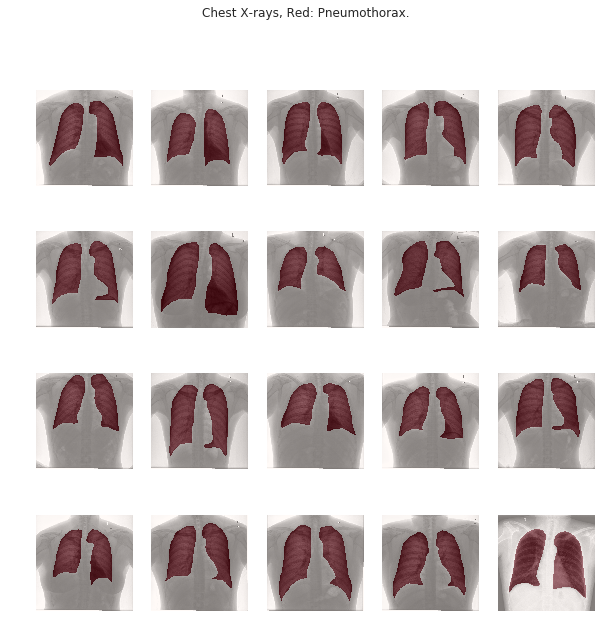

In [14]:
a = DataGenerator(batch_size=20,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 20
grid_width = 5
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(10, 10))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [15]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [16]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:
def unet(input_size=(256,256,3)):
    inputs = keras.layers.Input((img_size, img_size, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [18]:
# model = unet(input_size=img_size)
# model.summary()

In [19]:
import segmentation_models as sm
model = sm.Unet('seresnet34', input_shape=(img_size,img_size,3), encoder_weights='imagenet',decoder_block_type='transpose')

Segmentation Models: using `keras` framework.
86319104/86315168 [==============================] - 1s 0us/step


In [20]:
def get_iou_vector(A,B):
    batch_size = A.shape[0]
    metric = 0.0
    for i in range(batch_size):
        t,p = A[i],B[i]
        intersection = np.sum(t * p)
        true = np.sum(t)
        pred = np.sum(p)
        
        if(true == 0):
            metric += (pred == 0)
            
        union = true + pred - intersection
        iou = intersection / union
        iou = np.floor(max(0,(iou - 0.45) * 20)) / 10
        metric += iou
    return metric / batch_size
def iou_metric(label,pred):
    return tf.py_func(get_iou_vector,[label,pred > 0.5],tf.float64)

In [21]:
def dice_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    #y_pred_f = K.cast(K.greater(K.flatten(y_pred),0.5),'float32')
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return dice_coeff
def dice_loss(y_true,y_pred):   
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2 + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice_coeff
def bce_dice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) + dice_loss(y_true,y_pred)
def bce_logdice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) - K.log(1. - dice_loss(y_true,y_pred))

In [22]:
# !pip install -U segmentation-models
# import segmentation_models as sm
# model = sm.Unet('resnet34', input_shape=(img_size,img_size,3), encoder_weights='imagenet',decoder_block_type='transpose')

In [23]:
model.compile(loss = bce_dice_loss,optimizer = Adam(3e-4),metrics = [iou_metric])

In [24]:
img_size = 1024
epochs = 50
batch_size = 4
train_generator = DataGenerator(train_im_path = train_im_path, train_mask_path = train_mask_path, batch_size = batch_size)
#val_generator = DataGenerator(train_im_path = val_im_path, train_mask_path = val_mask_path, batch_size = batch_size)
callbacks = [ModelCheckpoint('best_model.h5',save_best_only = True,monitor = 'iou_metric', mode = 'max', verbose = 1)]
history = model.fit_generator(train_generator,epochs = epochs,callbacks = callbacks)

Epoch 1/50
176/176 [==============================] - 337s 2s/step - loss: 0.4553 - iou_metric: 0.8085

Epoch 00001: iou_metric improved from -inf to 0.80852, saving model to best_model.h5
Epoch 2/50
  4/176 [..............................] - ETA: 1:57 - loss: 0.1794 - iou_metric: 0.9125

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater


176/176 [==============================] - 298s 2s/step - loss: 0.1557 - iou_metric: 0.9101

Epoch 00002: iou_metric improved from 0.80852 to 0.91009, saving model to best_model.h5
Epoch 3/50
176/176 [==============================] - 321s 2s/step - loss: 0.1164 - iou_metric: 0.9192

Epoch 00003: iou_metric improved from 0.91009 to 0.91918, saving model to best_model.h5
Epoch 4/50
176/176 [==============================] - 322s 2s/step - loss: 0.1000 - iou_metric: 0.9293

Epoch 00004: iou_metric improved from 0.91918 to 0.92926, saving model to best_model.h5
Epoch 5/50
176/176 [==============================] - 322s 2s/step - loss: 0.0928 - iou_metric: 0.9311

Epoch 00005: iou_metric improved from 0.92926 to 0.93111, saving model to best_model.h5
Epoch 6/50
176/176 [==============================] - 320s 2s/step - loss: 0.0835 - iou_metric: 0.9415

Epoch 00006: iou_metric improved from 0.93111 to 0.94148, saving model to best_model.h5
Epoch 7/50
176/176 [==============================]

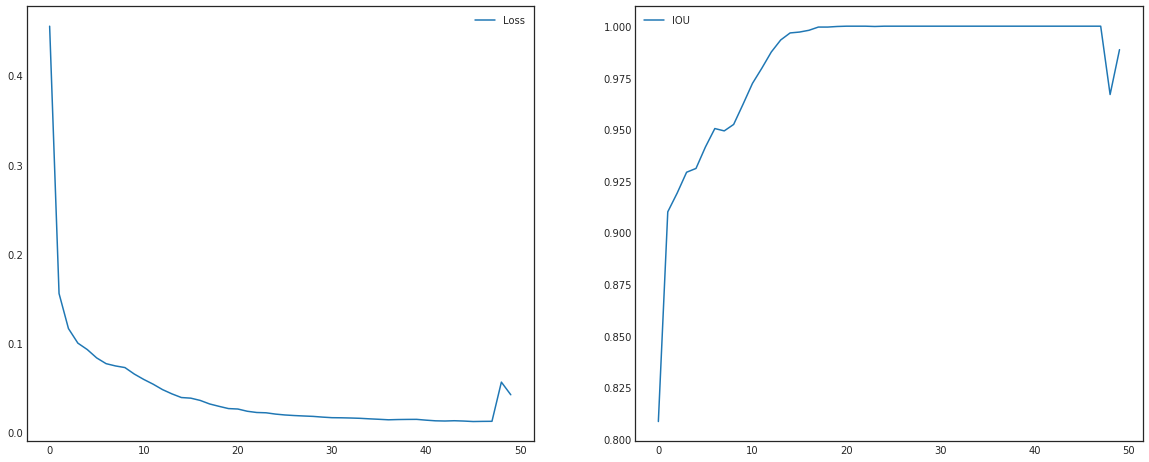

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.plot(history.history['loss'], '-', label = 'Loss')
#ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(np.array(history.history['iou_metric']), '-', 
         label = 'IOU')
# ax2.plot(np.array(history.history['val_iou_metric']), '-',
#          label = 'Validation IOU')
ax2.legend()


In [26]:
plt.savefig('train.png')

<Figure size 432x288 with 0 Axes>